## Calculate ratios and relative abundances of important proteins

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

pd.options.mode.copy_on_write = True
pd.options.mode.chained_assignment = None

### Read intensities from Excel sheet

In [2]:
# Read log2-transformed LFQ intensity from shaving data
shaving = pd.read_excel('input_files/20220216_identified_quantified_proteins_shaving.xlsx', #noqa: E501
                   sheet_name = 'quantified_proteins',
                   header = 1)

# Read Z-score abundance from supernatant data
sn = pd.read_excel('input_files/20220428_identified_quantified_supernatant.xlsx',
                   sheet_name = 'quantified_proteins',
                   header = 1)

# Fix stupid names with spaces
shaving.columns = shaving.columns.str.replace(' ', '')
sn.columns = sn.columns.str.replace(' ', '')

shaving = shaving[:-1]
sn = sn[:-1]

### Define Conditions

In [3]:
include_dict = {'Fructose_20h': ['F20_1','F20_2','F20_3'],
                'RS_20h': ['resistantS20_1','resistantS20_2','resistantS20_3'],
                'Pullulan_20h': ['P20_1','P20_2','P20_3'],
                'Starch_20h': ['S20_1','S20_2','S20_3']}

# Protein ID should always be there
include_conditions = []

for conditions in include_dict.values():
    include_conditions = include_conditions + conditions

# Let's make a minimal dataframe, 20h Fruc vs. 20h RS
shaving = shaving[['MajorityproteinIDs', *include_conditions]]
sn = sn[['MajorityproteinIDs', *include_conditions]]

# Drop all proteins which are not identified in any triplicate of any condition
protein_identified_shaving = shaving[include_conditions].notna().any(axis=1)
shaving = shaving[protein_identified_shaving]

protein_identified_sn = sn[include_conditions].notna().any(axis=1)
sn = sn[protein_identified_sn]

In [4]:
# Add mean abundance
conditions_mean = {}

for key, value in include_dict.items():
    name_mean = f'{key}_mean'
    conditions_mean[key] = name_mean

    shaving[name_mean] = shaving[value].mean(axis=1, skipna = True)
    sn[name_mean] = sn[value].mean(axis=1, skipna = True)

### Calculate Shares of Amylosome components

In [5]:
# Load full protein info
full_sequences = pd.read_csv("input_files/sequences_annotated.csv",
                            index_col = 0)

# Merge
shaving_annotated = shaving.merge(full_sequences[['SeqID',
                                                  'shortname',
                                                  'amylosome_component']],
                                  left_on = 'MajorityproteinIDs',
                                  right_on = 'SeqID',
                                  how = 'left',
                                  validate = '1:m')

sn_annotated = sn.merge(full_sequences[['SeqID',
                                        'shortname',
                                        'amylosome_component']],
                        left_on = 'MajorityproteinIDs',
                        right_on = 'SeqID',
                        how = 'left',
                        validate = '1:m')

# Make Dataset of Dockerin-containing enzymes
shaving_annotated.amylosome_component = shaving_annotated.amylosome_component.astype('boolean') #noqa: E501
sn_annotated.amylosome_component = sn_annotated.amylosome_component.astype('boolean')

In [6]:
comp_doc = shaving_annotated[shaving_annotated.amylosome_component]

# Results DataFrame
share_doc = pd.DataFrame()

for col in include_conditions:
    name = f'{col}_raw'

    # Backtransform log2-transformed LFQ values.
    comp_doc[name] = 2 ** comp_doc[col]

    # Calculate share for each protein
    for spe_id in shaving_annotated[shaving_annotated.amylosome_component]["SeqID"].to_list(): #noqa: E501
        share_doc.loc[col, spe_id] = float(comp_doc[comp_doc.SeqID == spe_id][name].item()) / comp_doc[name].sum()*100 #noqa: E501

In [7]:
sn_doc = sn_annotated[sn_annotated.amylosome_component]

# Results DataFrame
share_doc_sn = pd.DataFrame()

for col in include_conditions:
    name = f'{col}_raw'

    # As suggested by Anke, set lowest value to 0 and then to %
    sn_doc[name] = sn_doc[col] - sn_doc[col].min()

    # Calculate share for each protein
    for spe_id in sn_annotated[sn_annotated.amylosome_component]["SeqID"].to_list():
        share_doc_sn.loc[col, spe_id] = float(sn_doc[sn_doc.SeqID == spe_id][name].item()) / sn_doc[name].sum()*100 #noqa: E501

##### Cluster into Useful Groups

In [8]:
groups = {"Amy4": ["SPE91379.1"],
          "Amy9": ["SPE92705.1"],
          "Amy16": ["SPE92332.1"],
          "Amy10": ["SPE91787.1"],
          "Amy12": ["SPE92040.1"],
          "Sas": ["SPE92126.1", # Sas6
                  "SPE90846.1"], # Sas20
          "Sca": ['SPE91525.1', # Sca4
                  "SPE91427.1", # Sca3
                  "SPE91760.1"],# Sca2
          "Other": ["SPE91140.1",
                    "SPE92295.1",
                    "SPE92531.1",
                    "SPE92612.1",
                    "SPE91138.1",
                    "SPE92254.1",
                    "SPE92532.1",
                    "SPE91410.1",
                    "SPE91002.1",
                    "SPE91000.1"],
          }

groups_sn = {"Amy4": ["SPE91379.1"],
          "Amy9": ["SPE92705.1"],
          "Amy16": ["SPE92332.1"],
          "Amy10": ["SPE91787.1"],
          "Amy12": ["SPE92040.1"],
          "Sas": ["SPE92126.1", # Sas6
                  "SPE90846.1"], # Sas20
          "Sca": ['SPE91525.1', # Sca4
                  "SPE91427.1", # Sca3
                  "SPE91760.1", # Sca2
                  "SPE91757.1"],# Sca5
          "Other": ["SPE90879.1",
                    "SPE91000.1",
                    "SPE91002.1",
                    "SPE91138.1",
                    "SPE91140.1",
                    "SPE91187.1",
                    "SPE91277.1",
                    "SPE91410.1",
                    "SPE91413.1",
                    "SPE92085.1",
                    "SPE92254.1",
                    "SPE92531.1",
                    "SPE92532.1",
                    "SPE92550.1",
                    "SPE92612.1",
                    "SPE92807.1"],
          }

clustered_df = pd.DataFrame()
clustered_df_sn = pd.DataFrame()

for cluster, ids in groups.items():
    clustered_df[cluster] = share_doc[ids].sum(axis=1)

for cluster, ids in groups_sn.items():
    clustered_df_sn[cluster] = share_doc_sn[ids].sum(axis=1)

clustered_mean = clustered_df.groupby(clustered_df.index.str[0]).mean()
clustered_mean_sn = clustered_df_sn.groupby(clustered_df_sn.index.str[0]).mean()

##### Plot

/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_3399/3161906683.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=samples,


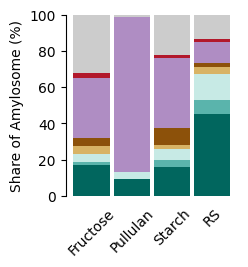

In [9]:
inch = 2.54 # one inch is 2.54 cm

fig, ax = plt.subplots(figsize=(6.5 / inch,
                                7 / inch))

bottom = np.zeros(4)

cmap = {'Amy4': "#01665e",
        'Amy9': "#5ab4ac",
        'Amy16': "#c7eae5",
        'Amy10': "#d8b365",
        'Amy12': "#8c510a",
        'Sas': "#af8dc3",
        'Sca': "#b2182b",
        'Other': '#cccccc'}

samples = ["Fructose",
           "Pullulan",
           "Starch",
           "RS"]

for protein, row in clustered_mean.T.iterrows():
    p = ax.bar(samples,
               row.values,
               0.9,
               label=protein,
               bottom=bottom,
               color = cmap[protein]
               )
    bottom += row.values

ax.set_ylabel("Share of Amylosome (%)",
              fontsize = 10)
ax.set_ylim([0,100])


ax.set_xlabel('')
ax.set_xticklabels(labels=samples,
                   rotation = 45,
                   fontsize = 10,)

ax.xaxis.set_ticks_position('none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.tight_layout(pad=1)

/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_3399/242140814.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=samples,


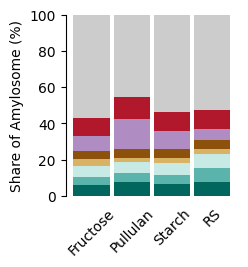

In [10]:
inch = 2.54 # one inch is 2.54 cm

fig, ax = plt.subplots(figsize=(6.5 / inch,
                                7 / inch))

bottom = np.zeros(4)

cmap = {'Amy4': "#01665e",
        'Amy9': "#5ab4ac",
        'Amy16': "#c7eae5",
        'Amy10': "#d8b365",
        'Amy12': "#8c510a",
        'Sas': "#af8dc3",
        'Sca': "#b2182b",
        'Other': '#cccccc'}

samples = ["Fructose",
           "Pullulan",
           "Starch",
           "RS"]

for protein, row in clustered_mean_sn.T.iterrows():
    p = ax.bar(samples,
               row.values,
               0.9,
               label=protein,
               bottom=bottom,
               color = cmap[protein]
               )
    bottom += row.values

ax.set_ylabel("Share of Amylosome (%)",
              fontsize = 10)
ax.set_ylim([0,100])


ax.set_xlabel('')
ax.set_xticklabels(labels=samples,
                   rotation = 45,
                   fontsize = 10,)

ax.xaxis.set_ticks_position('none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.tight_layout(pad=1)

#### CAZyme shares in cell-associated

In [11]:
Amy_dict = {'Amy16': 'SPE92332.1',
            'Amy12': 'SPE92040.1',
            'Amy10': 'SPE91787.1',
            'Amy4': 'SPE91379.1',
            'Amy9': 'SPE92705.1'}

In [12]:
# Results DataFrame
share_doc = pd.DataFrame(data=Amy_dict,
                        index = ['uid'])

for col in include_conditions:
    name = f'{col}_raw'

    # Calculate share for each Amy
    for protein, spe_id in Amy_dict.items():
        share_doc.loc[col, protein] = float(comp_doc[comp_doc.SeqID == spe_id][name].item()) / comp_doc[name].sum()*100 #noqa: E501

share_doc

,Amy16,Amy12,Amy10,Amy4,Amy9
uid,SPE92332.1,SPE92040.1,SPE91787.1,SPE91379.1,SPE92705.1
F20_1,3.914053,4.00815,4.143202,17.795843,1.569318
F20_2,4.888264,5.505992,4.558342,16.616544,1.623001
F20_3,4.830871,4.483765,4.476793,16.361011,1.385068
resistantS20_1,11.253596,1.103461,4.148775,42.0185,9.938901
resistantS20_2,13.315902,2.056304,3.750297,47.618663,6.969952
resistantS20_3,18.6811,2.119617,4.62729,45.39129,6.228349
P20_1,1.755681,NaN,NaN,9.853502,NaN
P20_2,7.182484,NaN,NaN,9.130895,NaN
P20_3,2.694161,NaN,NaN,9.378942,NaN


#### CAZyme shares in supernatant

In [13]:
# Results DataFrame
share_doc_sn = pd.DataFrame(data=Amy_dict,
                        index = ['uid'])

for col in include_conditions:
    name = f'{col}_raw'

    # Calculate share for each Amy
    for protein, spe_id in Amy_dict.items():
        share_doc_sn.loc[col, protein] = float(sn_doc[sn_doc.SeqID == spe_id][name].item()) / sn_doc[name].sum()*100 #noqa: E501

share_doc_sn

,Amy16,Amy12,Amy10,Amy4,Amy9
uid,SPE92332.1,SPE92040.1,SPE91787.1,SPE91379.1,SPE92705.1
F20_1,7.510068,4.606476,3.985996,6.514674,5.152733
F20_2,5.265955,4.20174,3.900332,5.436972,4.415456
F20_3,5.235742,3.950847,3.738025,5.388031,4.225243
resistantS20_1,7.174423,5.222693,2.865158,7.411494,8.119585
resistantS20_2,7.306357,4.264757,2.718098,6.931309,7.351039
resistantS20_3,8.892088,4.460524,3.250846,8.106156,8.119976
P20_1,2.31587,2.060311,NaN,4.404542,0.840427
P20_2,8.079685,6.683233,2.879239,9.510263,7.438682
P20_3,7.779535,6.534986,2.415457,9.623756,6.724195
